# Does replaying the same movie clip reduce the variability of resting-state fMRI?

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the functional connectivity matrices

In [116]:
# Keep only upper-triangle since the FC matrix is symmetric (does the diagonal of our FC contain only ones ? if yes can discard the diagonal, if not have to keep it 

# Generate a random matrix of size 2080x36
fc_concat = np.random.rand(2080, 36)
print(fc_concat.shape)

(2080, 36)


## Run PCA to estimate the residual variance for each rsfMRI run

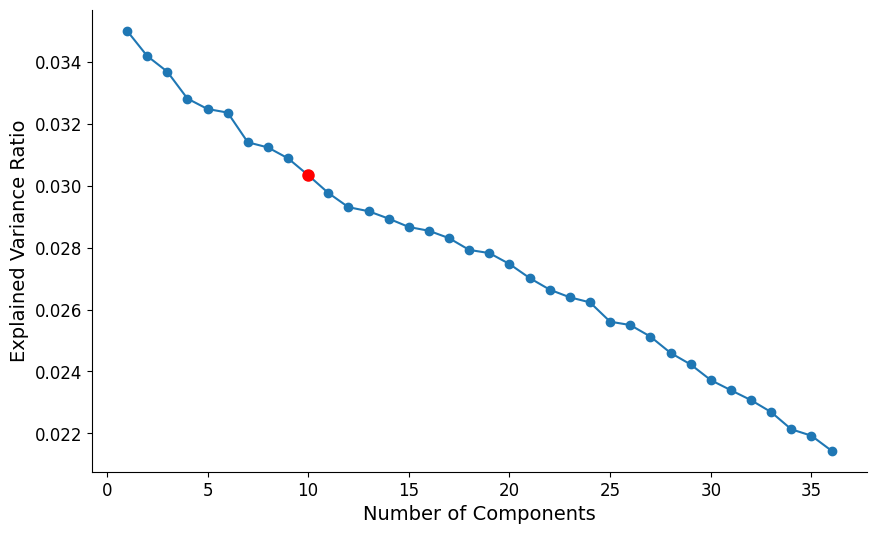

In [117]:
from sklearn.decomposition import PCA

# Run PCA
# Center the data by removing the mean from each column
fc_concat = fc_concat - np.mean(fc_concat, axis=0)

# Run PCA
pca = PCA()
pca.fit(fc_concat)

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

# Generate the elbow plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
ax.set_xlabel('Number of Components', fontsize=14)
ax.set_ylabel('Explained Variance Ratio', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Define the number of components to keep
n_comp = 10

# Highlight the points corresponding to number of components we keep in red
ax.plot(n_comp, explained_variance[n_comp-1], marker='o', markersize=8, color='red')

plt.show()

We are using the elbow plot to decide the number of principal components to keep.

## Reconstruct the FC with a limited number of components

After extracting the principal components, each FC matrix can be expressed as a linear combinations of the principal components plus a residual matrix.

In [118]:
print(pca.components_.shape)
# Project PC components back into each FC subject space
fc_projected = pca.transform(fc_concat)[:, :n_comp]
print(fc_projected.shape)
fc_reconstructed = np.dot(fc_projected, pca.components_[:n_comp, :]) + np.mean(fc_concat, axis=0)
print(fc_reconstructed.shape)

(36, 36)
(2080, 10)
(2080, 36)


## Compute the residual matrix

In [119]:
# Calculate the residuals as the difference between the full and reconstructed FC matrices
residuals = fc_concat - fc_reconstructed
print(residuals.shape)

(2080, 36)


In [120]:
import numpy as np
from sklearn.decomposition import PCA

# Project the data onto the residual components (from n_comp + 1 onwards)
residuals_frompc = pca.transform(fc_concat)[:, n_comp:]

# Reconstruct the data using the residual components
residuals_frompc = np.dot(residuals_frompc, pca.components_[n_comp:, :]) + np.mean(fc_concat, axis=0)

# Print the shape of the reconstructed data
print(residuals_frompc.shape)


(2080, 36)


## Plot residual matrix

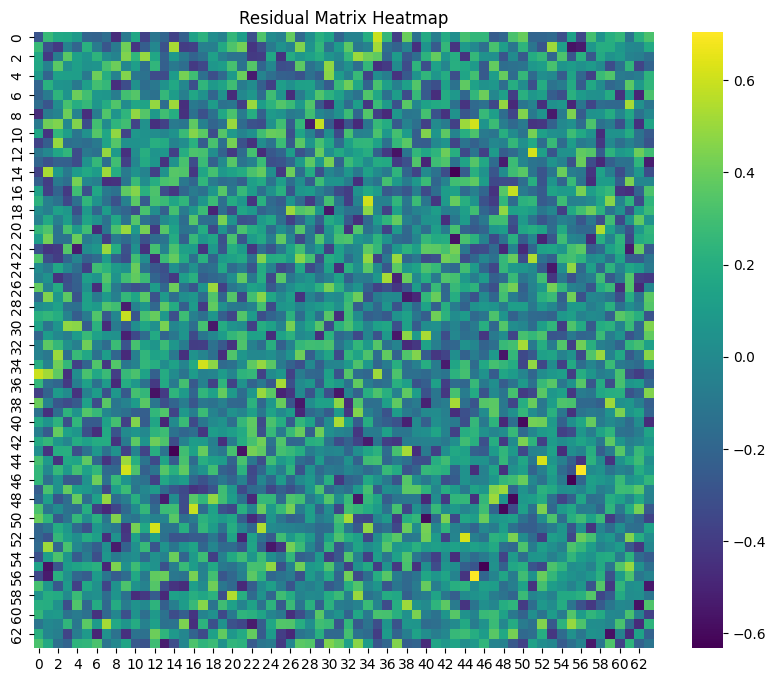

In [121]:
# Function to reconstruct the full matrix from the upper triangle
def reconstruct_full_matrix(upper_triangle, size):
    full_matrix = np.zeros((size, size))
    upper_indices = np.triu_indices(size)
    full_matrix[upper_indices] = upper_triangle
    full_matrix = full_matrix + full_matrix.T - np.diag(np.diag(full_matrix))
    return full_matrix


# Assuming the size of the original FC matrix is 64x64
size = 64
residual = reconstruct_full_matrix(residuals[:,0], size)


# Plot the residual matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(residual, cmap='viridis')
plt.title('Residual Matrix Heatmap')
plt.show()

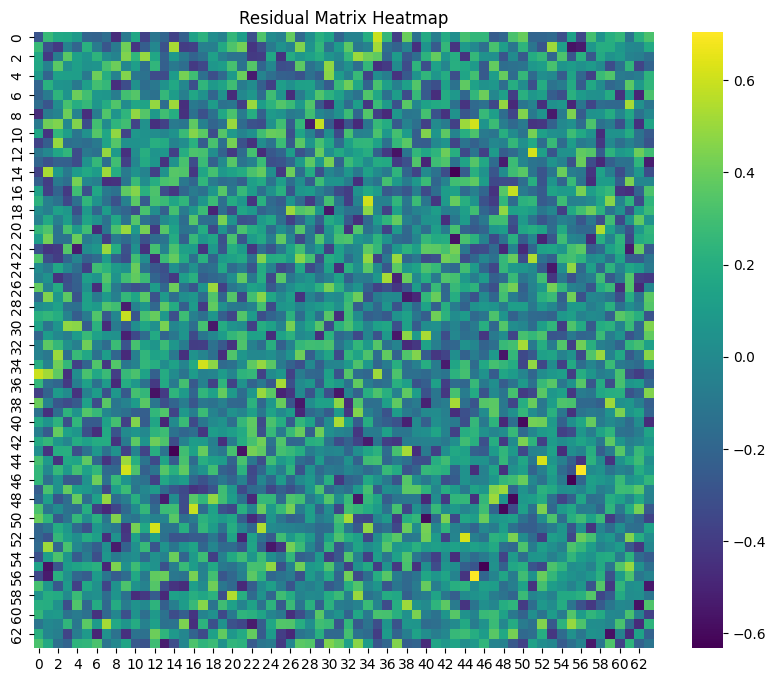

In [122]:
# Assuming the size of the original FC matrix is 64x64
size = 64
residual_frompc = reconstruct_full_matrix(residuals_frompc[:,0], size)


# Plot the residual matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(residual_frompc, cmap='viridis')
plt.title('Residual Matrix Heatmap')
plt.show()

## Plot the variance of the residuals over sessions

(2080,)


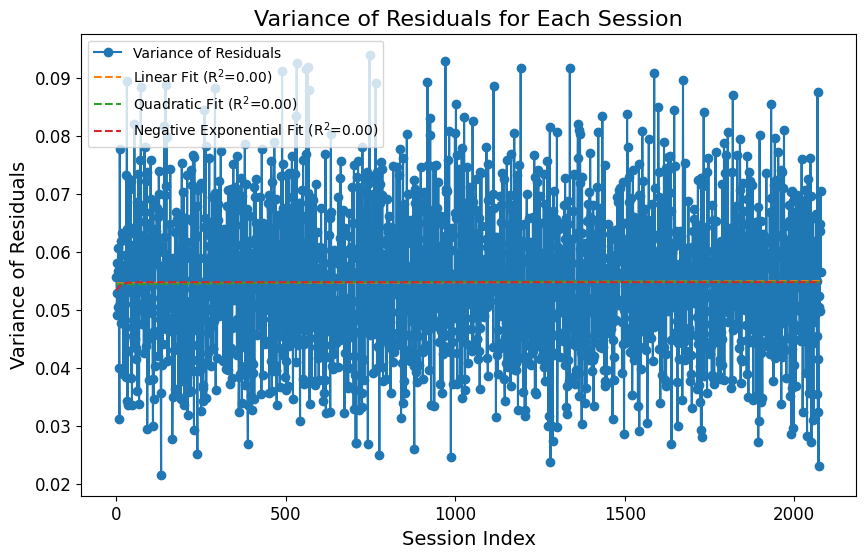

In [123]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Compute the variance of the residuals for each session
residuals_var = np.var(residuals, axis=1)
print(residuals_var.shape)

# Plot the variance of the residuals as a function of the session index
plt.figure(figsize=(10, 6))
plt.plot(range(len(residuals_var)), residuals_var, marker='o', linestyle='-', label='Variance of Residuals')

# Fit and plot a linear curve
linear_model = np.poly1d(np.polyfit(range(len(residuals_var)), residuals_var, 1))
linear_r2 = r2_score(residuals_var, linear_model(range(len(residuals_var))))
plt.plot(range(len(residuals_var)), linear_model(range(len(residuals_var))), linestyle='--', label=f'Linear Fit (R$^2$={linear_r2:.2f})')

# Fit and plot a quadratic curve
quadratic_model = np.poly1d(np.polyfit(range(len(residuals_var)), residuals_var, 2))
quadratic_r2 = r2_score(residuals_var, quadratic_model(range(len(residuals_var))))
plt.plot(range(len(residuals_var)), quadratic_model(range(len(residuals_var))), linestyle='--', label=f'Quadratic Fit (R$^2$={quadratic_r2:.2f})')

# Fit and plot a negative exponential curve
def neg_exp(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, _ = curve_fit(neg_exp, range(len(residuals_var)), residuals_var, p0=(1, 0.01, 1))
neg_exp_r2 = r2_score(residuals_var, neg_exp(range(len(residuals_var)), *popt))
plt.plot(range(len(residuals_var)), neg_exp(range(len(residuals_var)), *popt), linestyle='--', label=f'Negative Exponential Fit (R$^2$={neg_exp_r2:.2f})')

plt.xlabel('Session Index', fontsize=14)
plt.ylabel('Variance of Residuals', fontsize=14)
plt.title('Variance of Residuals for Each Session', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend()
plt.show()

## Plot edgewise residual over sessions

(36,)
(36,)


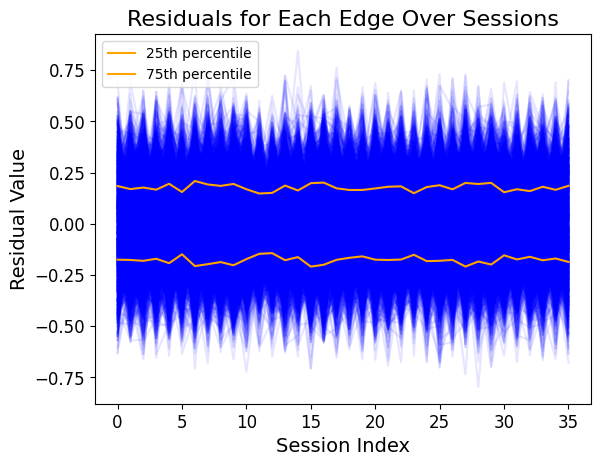

In [125]:
from sklearn.linear_model import LinearRegression

# Calculate the interquartile range (IQR)
q1 = np.percentile(residuals, 25, axis=0)
q3 = np.percentile(residuals, 75, axis=0)
print(q1.shape)
print(q3.shape)

# Plot the evolution of the residual for each edge
for i in range(residuals.shape[0]):
    plt.plot(range(residuals.shape[1]), residuals[i,:], color='blue', alpha=0.1)

# Plot the inter-quartile
plt.plot(range(residuals.shape[1]), q1, color='orange', label='25th percentile')
plt.plot(range(residuals.shape[1]), q3, color='orange', label='75th percentile')


plt.xlabel('Session Index', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)
plt.title('Residuals for Each Edge Over Sessions', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend()
plt.show()